In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import holoviews as hv
# hv.extension('bokeh')
import hvplot.xarray
import hvplot.pandas
from bokeh.models import DatetimeTickFormatter
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
# import whenever 
import glob
import os
import pytz
from timezonefinder import TimezoneFinder
import time

In [2]:
# Import site metadata csv
timedelta = 'DD'

filepath = 'ameriflux-data/'
meta_file = filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only

In [3]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [4]:
# Pick a site
site_ID = 'US-Ne1'

# Testing Micasa with VirtualiZarr

In [5]:
# Open site ID metadata and extract lat/lon
filepath = 'ameriflux-data/'
meta_file = filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
site_lat = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values
# print(site_lat, site_lon)

# Open site data and access time indices
site_file = get_single_match(filepath + 'AMF_' + site_ID + 
                            '_FLUXNET_SUBSET_*/AMF_' + site_ID + 
                            '_FLUXNET_SUBSET_' + timedelta + '*.csv')
# print(site_file)
fluxnet_sel = pd.read_csv(site_file)

# select subset of columns + convert to datetime objects
if timedelta == 'HH':
    fluxnet_sel_dates = fluxnet_sel.loc[:,['TIMESTAMP_START','TIMESTAMP_END']].copy()
    fluxnet_sel_dates['TIMESTAMP_START'] = pd.to_datetime(fluxnet_sel_dates['TIMESTAMP_START'],format='%Y%m%d%H%M')
    fluxnet_sel_dates['TIMESTAMP_END'] = pd.to_datetime(fluxnet_sel_dates['TIMESTAMP_END'],format='%Y%m%d%H%M')
    
    # Convert time to UTC
    fluxnet_sel_dates = local_std_to_utc_std(fluxnet_sel_dates,'TIMESTAMP_START',site_lat, site_lon)
    fluxnet_sel_dates = fluxnet_sel_dates.set_index('utc_time')

if timedelta == 'DD':
    fluxnet_sel_dates = fluxnet_sel.loc[:,['TIMESTAMP']].copy()
    fluxnet_sel_dates['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_dates['TIMESTAMP'],format='%Y%m%d')
    fluxnet_sel_dates = fluxnet_sel_dates.set_index('TIMESTAMP')

# Create a list of unique dates from the site
time = fluxnet_sel_dates.index
dates_unique = list({dt.date() for dt in time})
dates_unique.sort()
print(dates_unique[0], dates_unique[-1], len(dates_unique), sep=', ')


2001-01-01, 2020-12-31, 7305


In [6]:
# That is a lot of data, let's try just with first 1000 points
dates_unique = dates_unique[:1001]


In [7]:
# Get a list of paths we want for micasa 
path = 'micasa-data/daily-0.1deg-final/holding/'
if timedelta == 'HH':
    data_path = path + '3hrly/'

if timedelta == 'DD':
    data_path = path + 'daily/'

path_list = []

for date in dates_unique:
    f_year = str(date.year)
    f_month = f"{date.month:02}" 
    filename = 'MiCASA_v1_flux_*' + date.strftime('%Y%m%d') + '.nc4'
    filepath = get_single_match(os.path.join(data_path,f_year,f_month,filename))
    path_list.append(filepath)

# # Quick test
# print(dates_unique[-1])
# print(path_list[-1])

In [8]:
# import warnings
# warnings.filterwarnings("ignore")

In [13]:
#I'm getting an error with this cell but it ran before? because I have an existing output for combined.json
%%time
from virtualizarr import open_virtual_dataset

virtual_datasets = [
    open_virtual_dataset(filepath, indexes={}) #passing the indexes avoids a recurring warning I was getting
    for filepath in path_list
]

# this Dataset wraps a bunch of virtual ManifestArray objects directly
virtual_ds = xr.combine_nested(virtual_datasets, concat_dim=['time'])

# cache the combined dataset pattern to disk, in this case using the existing kerchunk specification for reference files
virtual_ds.virtualize.to_kerchunk('combined_test.json', format='json')

TypeError: Could not find a Chunk Manager which recognises type <class 'virtualizarr.manifests.array.ManifestArray'>

In [12]:
ds = xr.open_dataset('combined.json', engine='kerchunk', chunks={}) 
ds

<xarray.Dataset> Size: 1TB
Dimensions:    (time: 7305, lat: 1800, lon: 3600, nv: 2)
Coordinates:
  * lat        (lat) float64 14kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * lon        (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 58kB 2001-01-01 2001-01-02 ... 2020-12-31
Dimensions without coordinates: nv
Data variables:
    ATMC       (time, lat, lon) float32 189GB dask.array<chunksize=(1, 600, 1200), meta=np.ndarray>
    FIRE       (time, lat, lon) float32 189GB dask.array<chunksize=(1, 600, 1200), meta=np.ndarray>
    FUEL       (time, lat, lon) float32 189GB dask.array<chunksize=(1, 600, 1200), meta=np.ndarray>
    NEE        (time, lat, lon) float32 189GB dask.array<chunksize=(1, 600, 1200), meta=np.ndarray>
    NPP        (time, lat, lon) float32 189GB dask.array<chunksize=(1, 600, 1200), meta=np.ndarray>
    Rh         (time, lat, lon) float32 189GB dask.array<chunksize=(1, 600, 1200), meta=np.ndarray>
    time_bnds  (time, nv) float64 117kB dask.array<chunksize=(1, 2), meta=np.ndarray>

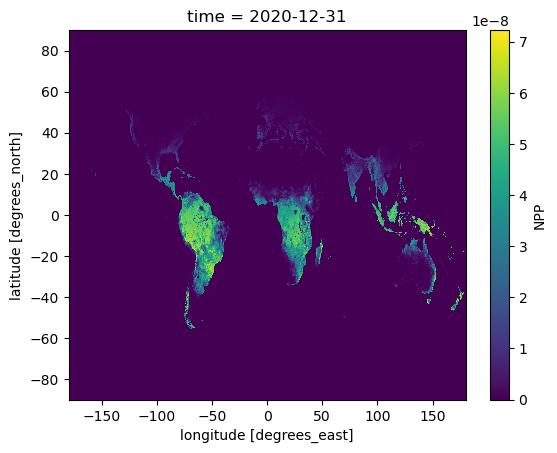

In [11]:
ds['NPP'].sel(time='2020-12-31').plot()